In [166]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [167]:
def load_photos(directory):
    images = []
    labels = []
    for name in listdir(directory):
        filename = directory + '/' + name
        # convert image to gray
        #img = Image.open(filename).convert('L')
        #img.save(filename)
        # load an image from file
        image = load_img(filename, target_size=(128, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value = round(float(name.split('_')[0].split('-')[0]) / float(name.split('_')[0].split('-')[1]), 1)
        if value <= 0.5:
            value = 0
        elif value <= 0.9:
            value = 1
        elif value > 0.9 and value < 1.1:
            value = 2
        elif value >= 1.1 and value < 1.5:
            value = 3
        elif value >= 1.5:
            value = 4
        labels.append(value)
        images.append(image)
    return images, labels

In [168]:
# load images from both train and test groups
directory = '../data/Patate_Pics/Training'
images, labels = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)
directory = '../data/Patate_Pics/Validation'
images_val, labels_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for training: 896
Loaded Images and labels for validation: 150


In [169]:
#normalise datas
images = np.array(images)
images_val = np.array(images_val)

In [170]:
#convert to np.array
labels = np.array(labels)
labels_val = np.array(labels_val)

In [171]:
#convert datas to dummyvalues
labelsd = pd.get_dummies(labels)

In [172]:
labelsd.shape
labelsd

,0,1,2,3,4
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,0,1,0
5,1,0,0,0,0
6,1,0,0,0,0
7,0,1,0,0,0
8,1,0,0,0,0
9,0,1,0,0,0


In [173]:
#convert to np.array again
labelsd = np.array(labelsd)

In [174]:
#check if OK
labels[1], labelsd[1]

(1, array([0, 1, 0, 0, 0], dtype=uint8))

In [175]:
from keras.models import Model
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [176]:
K.clear_session()

img_in = Input(shape=(128, 160, 3), name='img_in')

x = img_in

x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output
out = Dense(5, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [177]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 160, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 62, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 29, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 13, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 6, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 4, 64)          36928     
_________________________________________________________________
flattened (Flatten)          (None, 1536)              0         
__________

In [178]:
h = model.fit(images, labelsd, batch_size=1, epochs=20, verbose=1)

Epoch 1/20
896/896 [==============================] - 13s - loss: 1.5471 - acc: 0.3516    
Epoch 2/20
896/896 [==============================] - 13s - loss: 1.1974 - acc: 0.4397    
Epoch 3/20
896/896 [==============================] - 13s - loss: 0.9787 - acc: 0.6217    
Epoch 4/20
896/896 [==============================] - 13s - loss: 0.8903 - acc: 0.6562    
Epoch 5/20
896/896 [==============================] - 14s - loss: 0.7759 - acc: 0.6875    
Epoch 6/20
896/896 [==============================] - 22s - loss: 0.6472 - acc: 0.7600    
Epoch 7/20
896/896 [==============================] - 23s - loss: 0.4841 - acc: 0.8281    
Epoch 8/20
896/896 [==============================] - 22s - loss: 0.3098 - acc: 0.8940    
Epoch 9/20
896/896 [==============================] - 22s - loss: 0.1690 - acc: 0.9420    
Epoch 10/20
896/896 [==============================] - 24s - loss: 0.1249 - acc: 0.9699    
Epoch 11/20
896/896 [==============================] - 28s - loss: 0.0814 - acc: 0.9688  

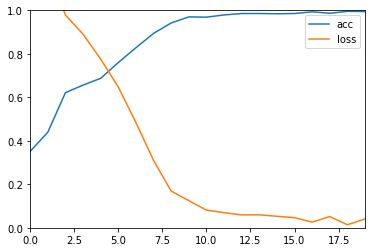

In [179]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [180]:
# Get predictions
all_preds = model.predict(images_val)

# Check predictions
idx = np.argmax(all_preds, axis=1)

i = 0
for value in idx:
    idx[i] = value
    i = i + 1

idx, labels_val

(array([3, 2, 2, 2, 3, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 3,
        1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3, 1, 2, 3, 3, 2, 1, 3,
        2, 2, 2, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 2, 1, 3, 3, 1,
        3, 3, 3, 3, 1, 3, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 2, 2, 3, 2, 3, 1, 3, 2, 3, 3, 3, 1, 1, 2, 3, 2, 3, 3, 3, 3, 2,
        3, 3, 2, 2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 1, 1,
        3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2], dtype=int64),
 array([4, 2, 2, 2, 2, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 3, 3, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 3,
        3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 2, 2, 

In [188]:
import math
i = 0
res = 0
for value in idx:
    if value == (0 or 1) and labels_val[i] == (3 or 4):
        res = res + 1
    i = i + 1
res/i

0.0

In [186]:
model.save('model-1x5.h5')

In [ ]:
from keras.models import load_model
model = load_model('test_model.h5')